This notebook fetches data from dbnomics to predict Swedish Exports for the most recent quarter (explanatory variables are timelier).


In [240]:
import pandas as pd
import numpy as np
from functools import reduce
from dbnomics import fetch_series, fetch_series_by_api_link

In [241]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [393]:
from xgboost import XGBRegressor

In [394]:
import graphviz
import eli5
from eli5.sklearn import PermutationImportance

### Fetch data

In [37]:
def fetcher(source, database, var_code, var_name):
    var = fetch_series(source, database, var_code)
    var = var.query("period >= '2010'")
    var = var[['period','value']]
    var = var.rename(columns = {'value':var_name})
    return var

In [43]:
# GDP and Exports
gdp = fetcher("OECD", "MEI", "SWE.NAEXCP01.STSA.Q", "gdp")
exports = fetcher("OECD", "MEI", "SWE.NAEXCP06.STSA.Q","exports")

# Prices
cpi = fetcher("OECD", "KEI", "CPALTT01.SWE.GP.M", "cpi")
ep  = fetcher("IMF", "PCPS", "M.W00.PNRG.IX", "energy_prices")
mp  = fetcher("IMF", "PCPS", "M.W00.PALLMETA.IX", "metal_prices")
ap  = fetcher("IMF", "PCPS", "M.W00.PRAWM.IX", "agri_prices")

# Economic activity
construction = fetcher("OECD", "MEI", "SWE.BCBUTE02.STSA.M", "construction")
retail = fetcher("OECD", "MEI", "SWE.BRBUTE02.STSA.M", "retail")
services = fetcher("OECD", "MEI", "SWE.BVBUTE02.STSA.M", "services")
manu_orders = fetcher("OECD", "MEI", "SWE.ODMNTO01.IXOBSA.M", "manu_orders")

# Business cycle
labour_cost = fetcher("OECD", "MEI", "SWE.LCLCPR01.IXOB.M", "labour_cost")
shares = fetcher("OECD", "MEI", "SWE.SPASTT01.GP.M", "shares")
interest = fetcher("OECD", "MEI", "SWE.IR3TTS01.ST.M", "interest")
interest10 = fetcher("OECD", "MEI", "SWE.IRLTLT01.ST.M", "interest10")
confidence = fetcher("OECD", "KEI", "BSCICP02.SWE.ST.M", "confidence")
excr = fetcher("OECD", "KEI", "CCUSMA02.SWE.ST.M", "exch_rate")

# Exports of largest partners
usimports = fetcher("OECD", "MEI", "USA.XTIMVA01.CXML.M", "usimports")
deimports = fetcher("OECD", "MEI", "DEU.XTIMVA01.CXML.M", "deimports")
noimports = fetcher("OECD", "MEI", "NOR.XTIMVA01.CXML.M", "noimports")
dkimports = fetcher("OECD", "MEI", "DNK.XTIMVA01.CXML.M", "dkimports")

In [84]:
# Features to merge
features = [cpi, ep, mp, ap, 
               construction, retail, services, manu_orders, 
               labour_cost, shares, interest, interest10,confidence, excr, 
               usimports, deimports, noimports, dkimports]

In [94]:
m = reduce(lambda left,right: pd.merge(left,right,on=['period'],
                                            how='outer'), features)

In [97]:
#m = reduce(lambda  left,right: pd.merge(left,right,on=['period'],
                                            #how='inner'), features)

In [100]:
m.tail()

,period,cpi,energy_prices,metal_prices,agri_prices,construction,retail,services,manu_orders,labour_cost,shares,interest,interest10,confidence,exch_rate,usimports,deimports,noimports,dkimports
154,2022-11-01,1.012915,256.859739,154.517386,105.618315,-16.3,-17.8,-4.7,107.915832,118.661647,9.187516,1.68,2.01,9.5,10.671123,256.545,134.979575,9.502326,10.419294
155,2022-12-01,2.069961,258.501791,164.732037,105.815678,-11.3,-17.4,NaN,133.466934,118.917383,0.773381,2.02,1.97,7.6,10.380418,252.758,121.393909,9.221288,10.068052
156,2023-01-01,-1.126376,223.272585,175.412945,107.503892,-23.2,-20.5,-3.7,105.811623,NaN,4.970249,2.66,2.08,4.6,10.379986,254.350,124.882073,7.634133,9.918318
157,2023-02-01,1.103448,201.718393,178.057382,106.985387,-39.6,-17.6,-1.6,NaN,NaN,2.965186,3.04,2.37,7.2,10.431615,NaN,NaN,7.620848,NaN
158,2023-03-01,NaN,NaN,NaN,NaN,-30.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
q = pd.merge(exports, gdp, on = 'period',  how = 'inner')

In [109]:
# Move period defining quarter from the first to the last month 
q['period'] = q['period'] + pd.DateOffset(months=2)

In [110]:
q.tail()

,period,exports,gdp
47,2021-12-01,681.799,1425.259
48,2022-03-01,727.036,1429.647
49,2022-06-01,757.111,1473.667
50,2022-09-01,795.567,1500.693
51,2022-12-01,825.807,1510.627


In [111]:
#df = pd.merge(m,q, on = 'period', how = 'left')
df = pd.merge(m,q, on = 'period', how = 'outer')

In [113]:
df.tail()

,period,cpi,energy_prices,metal_prices,agri_prices,construction,retail,services,manu_orders,labour_cost,...,interest,interest10,confidence,exch_rate,usimports,deimports,noimports,dkimports,exports,gdp
154,2022-11-01,1.012915,256.859739,154.517386,105.618315,-16.3,-17.8,-4.7,107.915832,118.661647,...,1.68,2.01,9.5,10.671123,256.545,134.979575,9.502326,10.419294,NaN,NaN
155,2022-12-01,2.069961,258.501791,164.732037,105.815678,-11.3,-17.4,NaN,133.466934,118.917383,...,2.02,1.97,7.6,10.380418,252.758,121.393909,9.221288,10.068052,825.807,1510.627
156,2023-01-01,-1.126376,223.272585,175.412945,107.503892,-23.2,-20.5,-3.7,105.811623,NaN,...,2.66,2.08,4.6,10.379986,254.350,124.882073,7.634133,9.918318,NaN,NaN
157,2023-02-01,1.103448,201.718393,178.057382,106.985387,-39.6,-17.6,-1.6,NaN,NaN,...,3.04,2.37,7.2,10.431615,NaN,NaN,7.620848,NaN,NaN,NaN
158,2023-03-01,NaN,NaN,NaN,NaN,-30.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
df['gdpm'] = df['gdp']/3
df['gdpm'] = df['gdpm'].fillna(method = 'bfill')

In [115]:
df['expm'] = df['exports']/3
df['expm'] = df['expm'].fillna(method = 'bfill')

In [116]:
df.tail()

,period,cpi,energy_prices,metal_prices,agri_prices,construction,retail,services,manu_orders,labour_cost,...,confidence,exch_rate,usimports,deimports,noimports,dkimports,exports,gdp,gdpm,expm
154,2022-11-01,1.012915,256.859739,154.517386,105.618315,-16.3,-17.8,-4.7,107.915832,118.661647,...,9.5,10.671123,256.545,134.979575,9.502326,10.419294,NaN,NaN,503.542333,275.269
155,2022-12-01,2.069961,258.501791,164.732037,105.815678,-11.3,-17.4,NaN,133.466934,118.917383,...,7.6,10.380418,252.758,121.393909,9.221288,10.068052,825.807,1510.627,503.542333,275.269
156,2023-01-01,-1.126376,223.272585,175.412945,107.503892,-23.2,-20.5,-3.7,105.811623,NaN,...,4.6,10.379986,254.350,124.882073,7.634133,9.918318,NaN,NaN,NaN,NaN
157,2023-02-01,1.103448,201.718393,178.057382,106.985387,-39.6,-17.6,-1.6,NaN,NaN,...,7.2,10.431615,NaN,NaN,7.620848,NaN,NaN,NaN,NaN,NaN
158,2023-03-01,NaN,NaN,NaN,NaN,-30.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:
df.drop(columns = ['gdp', 'exports'],  inplace = True)

In [118]:
df.rename(columns = {'gdpm': 'gdp', 'expm':'exports', 'period':'date'},  inplace = True)

In [119]:
df.tail()

,date,cpi,energy_prices,metal_prices,agri_prices,construction,retail,services,manu_orders,labour_cost,...,interest,interest10,confidence,exch_rate,usimports,deimports,noimports,dkimports,gdp,exports
154,2022-11-01,1.012915,256.859739,154.517386,105.618315,-16.3,-17.8,-4.7,107.915832,118.661647,...,1.68,2.01,9.5,10.671123,256.545,134.979575,9.502326,10.419294,503.542333,275.269
155,2022-12-01,2.069961,258.501791,164.732037,105.815678,-11.3,-17.4,NaN,133.466934,118.917383,...,2.02,1.97,7.6,10.380418,252.758,121.393909,9.221288,10.068052,503.542333,275.269
156,2023-01-01,-1.126376,223.272585,175.412945,107.503892,-23.2,-20.5,-3.7,105.811623,NaN,...,2.66,2.08,4.6,10.379986,254.350,124.882073,7.634133,9.918318,NaN,NaN
157,2023-02-01,1.103448,201.718393,178.057382,106.985387,-39.6,-17.6,-1.6,NaN,NaN,...,3.04,2.37,7.2,10.431615,NaN,NaN,7.620848,NaN,NaN,NaN
158,2023-03-01,NaN,NaN,NaN,NaN,-30.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
data = df

### Pre-process

In [374]:
# Train and test split

# Dates
train_start_date = "2010-01-01"
train_end_date = "2021-03-01"
test_start_date = "2021-04-01"
test_end_date = "2022-12-01"

# Split
train = data.loc[(data['date']>= train_start_date) & (data['date'] <= train_end_date), :].reset_index(drop = True)
test = data.loc[(data['date'] >= train_start_date) & (data['date'] <= test_end_date), :].reset_index(drop = True)
#test = data.loc[(data['date'] >= test_start_date) & (data['date'] <= test_end_date), :].reset_index(drop = True)

In [375]:
# Target variable
target_variable = 'exports' 

In [376]:
# Impute by forward filling
train_processed = train.fillna(method = 'ffill')

In [377]:
# Impute remaining missing observations by backward filling
train_processed = train_processed.fillna(method = 'bfill')

In [378]:
#continuous = train_processed.select_dtypes(include = [np.number]).columns

In [379]:
#train_processed[continuous] = StandardScaler().fit_transform(train_processed[continuous])

In [380]:
train_processed.tail()

,date,cpi,energy_prices,metal_prices,agri_prices,construction,retail,services,manu_orders,labour_cost,...,interest,interest10,confidence,exch_rate,usimports,deimports,noimports,dkimports,gdp,exports
130,2020-11-01,0.008903,100.895412,155.349847,108.785216,-31.2,22.2,9.2,111.823647,113.291184,...,-0.12,-0.03,7.2,8.648295,212.293,112.674713,7.859726,9.182414,428.869000,194.704667
131,2020-12-01,0.694362,118.493980,166.192411,107.590485,-30.2,5.6,-2.0,116.633267,114.484620,...,-0.18,0.01,5.8,8.364065,214.809,104.659891,7.418311,9.197491,428.869000,194.704667
132,2021-01-01,-0.368362,138.446272,171.609533,110.412206,-24.2,-1.5,5.3,114.929860,114.825602,...,-0.15,0.07,13.4,8.287952,204.945,102.503906,6.531250,8.740827,440.317333,197.778333
133,2021-02-01,0.272117,137.664908,171.445060,111.308442,-9.9,5.4,10.4,115.230461,114.825602,...,-0.13,0.25,14.4,8.333805,193.568,108.645119,6.999758,9.417825,440.317333,197.778333
134,2021-03-01,0.156338,142.136548,171.088881,114.475603,-4.8,5.7,6.4,114.428858,113.376430,...,-0.16,0.40,17.1,8.541243,237.001,126.354503,8.635168,10.721415,440.317333,197.778333


In [381]:
X_train = train_processed.drop(["date", target_variable], axis=1)
y_train = train_processed[target_variable]

In [382]:
# Pre-process test data
test_processed = test.fillna(method = 'ffill')
test_processed = test_processed.fillna(method = 'bfill')
test_processed.tail()

,date,cpi,energy_prices,metal_prices,agri_prices,construction,retail,services,manu_orders,labour_cost,...,interest,interest10,confidence,exch_rate,usimports,deimports,noimports,dkimports,gdp,exports
151,2022-08-01,1.758780,376.412083,158.734847,117.685200,0.5,-3.8,14.2,111.523046,113.717411,...,1.13,1.61,19.0,10.376848,283.625,130.514151,9.272856,10.987890,500.231000,265.189
152,2022-09-01,1.429290,330.149586,151.220233,110.620482,-7.7,-12.0,13.0,113.727455,115.763302,...,1.51,2.08,12.6,10.880836,275.475,133.003177,9.334044,10.582117,500.231000,265.189
153,2022-10-01,0.216591,259.858676,148.620228,104.825132,-11.0,-23.1,0.2,108.917836,117.809192,...,1.60,2.20,8.3,11.128995,282.694,128.498605,8.715012,9.925985,503.542333,275.269
154,2022-11-01,1.012915,256.859739,154.517386,105.618315,-16.3,-17.8,-4.7,107.915832,118.661647,...,1.68,2.01,9.5,10.671123,256.545,134.979575,9.502326,10.419294,503.542333,275.269
155,2022-12-01,2.069961,258.501791,164.732037,105.815678,-11.3,-17.4,-4.7,133.466934,118.917383,...,2.02,1.97,7.6,10.380418,252.758,121.393909,9.221288,10.068052,503.542333,275.269


In [383]:
X_test= test_processed.drop(["date", target_variable], axis=1)
y_test = test_processed[target_variable]

### Train

In [409]:
%%capture --no-display
xgb = XGBRegressor(n_estimators = 50, learning_rate = 0.1)
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)

In [410]:
print("RMSE:", np.sqrt(mean_absolute_error(y_test, y_pred)))

RMSE: 2.725310481811049


In [411]:
gbm = XGBRegressor()

In [412]:
gbm_param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 5, 7]}


In [413]:
grid = GridSearchCV(estimator = gbm, 
                        param_grid = gbm_param_grid,    
                        scoring = 'neg_mean_absolute_error', 
                        cv = 4, 
                        verbose = 1)

In [414]:
%%capture --no-display
grid.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
       

In [415]:
print("Best parameters:", grid.best_params_)
print("Lowest RMSE:", np.sqrt(np.abs(grid.best_score_)))

Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1000}
Lowest RMSE: 2.973391332376187


In [416]:
y_pred_grid = grid.predict(X_test)

In [417]:
print("RMSE:", np.sqrt(mean_absolute_error(y_test, y_pred_grid)))

RMSE: 2.4515632381152264


### Evaluate performance

In [404]:
all_dates

0     2010-01-01
1     2010-02-01
2     2010-03-01
3     2010-04-01
4     2010-05-01
         ...    
151   2022-08-01
152   2022-09-01
153   2022-10-01
154   2022-11-01
155   2022-12-01
Name: date, Length: 156, dtype: datetime64[ns]

<AxesSubplot:xlabel='date'>

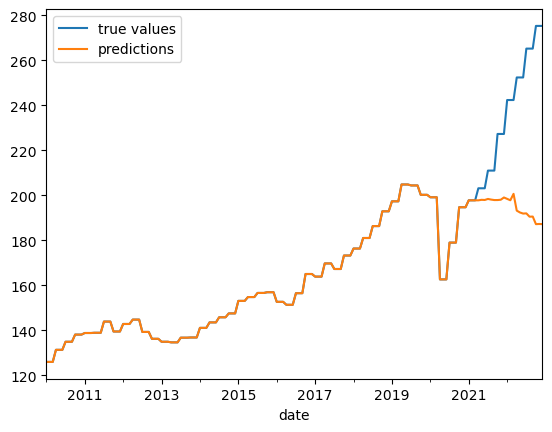

In [405]:
# plot of predictions vs test_values
pd.DataFrame({
    "true values":y_test.values, 
    "predictions":y_pred_grid},
    index = all_dates).plot()

### Feature importance: permutation importance

In [406]:
perm = PermutationImportance(xgb, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.6859 ± 0.1166,gdp
0.0583 ± 0.0211,labour_cost
0.0179 ± 0.0029,exch_rate
0.0088 ± 0.0032,manu_orders
0.0048 ± 0.0030,agri_prices
0.0034 ± 0.0044,energy_prices
0.0026 ± 0.0017,construction
0.0021 ± 0.0005,usimports
0.0012 ± 0.0049,interest10
0.0002 ± 0.0001,dkimports


### Predict

In [281]:
data.tail()

,date,cpi,energy_prices,metal_prices,agri_prices,construction,retail,services,manu_orders,labour_cost,...,interest,interest10,confidence,exch_rate,usimports,deimports,noimports,dkimports,gdp,exports
154,2022-11-01,1.012915,256.859739,154.517386,105.618315,-16.3,-17.8,-4.7,107.915832,118.661647,...,1.68,2.01,9.5,10.671123,256.545,134.979575,9.502326,10.419294,503.542333,275.269
155,2022-12-01,2.069961,258.501791,164.732037,105.815678,-11.3,-17.4,NaN,133.466934,118.917383,...,2.02,1.97,7.6,10.380418,252.758,121.393909,9.221288,10.068052,503.542333,275.269
156,2023-01-01,-1.126376,223.272585,175.412945,107.503892,-23.2,-20.5,-3.7,105.811623,NaN,...,2.66,2.08,4.6,10.379986,254.350,124.882073,7.634133,9.918318,NaN,NaN
157,2023-02-01,1.103448,201.718393,178.057382,106.985387,-39.6,-17.6,-1.6,NaN,NaN,...,3.04,2.37,7.2,10.431615,NaN,NaN,7.620848,NaN,NaN,NaN
158,2023-03-01,NaN,NaN,NaN,NaN,-30.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [348]:
prediction_date_assess = data['date'].max() 

In [349]:
# Share of variables with missing valies for the latest period
t0 = sum(data[data.date== prediction_date_assess].isnull().sum().values)/len(data.columns)
t1 = sum(data[data.date== prediction_date_assess - pd.DateOffset(months=1)].isnull().sum().values)/len(data.columns)

In [350]:
# Drop last month if share of variables with missing values is above 33%
if t0 > 0.33:
    prediction_date = data['date'].max() - pd.DateOffset(months=1)
else: 
    prediction_date = data['date'].max()
    
print(prediction_date)

2023-02-01 00:00:00


In [351]:
data_pred = data.loc[data.date <=  prediction_date]

In [352]:
data_pred.tail()

,date,cpi,energy_prices,metal_prices,agri_prices,construction,retail,services,manu_orders,labour_cost,...,interest,interest10,confidence,exch_rate,usimports,deimports,noimports,dkimports,gdp,exports
153,2022-10-01,0.216591,259.858676,148.620228,104.825132,-11.0,-23.1,0.2,108.917836,117.809192,...,1.60,2.20,8.3,11.128995,282.694,128.498605,8.715012,9.925985,503.542333,275.269
154,2022-11-01,1.012915,256.859739,154.517386,105.618315,-16.3,-17.8,-4.7,107.915832,118.661647,...,1.68,2.01,9.5,10.671123,256.545,134.979575,9.502326,10.419294,503.542333,275.269
155,2022-12-01,2.069961,258.501791,164.732037,105.815678,-11.3,-17.4,NaN,133.466934,118.917383,...,2.02,1.97,7.6,10.380418,252.758,121.393909,9.221288,10.068052,503.542333,275.269
156,2023-01-01,-1.126376,223.272585,175.412945,107.503892,-23.2,-20.5,-3.7,105.811623,NaN,...,2.66,2.08,4.6,10.379986,254.350,124.882073,7.634133,9.918318,NaN,NaN
157,2023-02-01,1.103448,201.718393,178.057382,106.985387,-39.6,-17.6,-1.6,NaN,NaN,...,3.04,2.37,7.2,10.431615,NaN,NaN,7.620848,NaN,NaN,NaN


In [353]:
data_pred = data.drop(['date', target_variable], axis = 1)

In [354]:
# Pre-process test data
data_pred_processed = data_pred.fillna(method = 'ffill')
data_pred_processed = data_pred_processed.fillna(method = 'bfill')
#test_processed[continuous] = StandardScaler().fit_transform(test_processed[continuous])

In [363]:
data_pred_processed.tail()

,cpi,energy_prices,metal_prices,agri_prices,construction,retail,services,manu_orders,labour_cost,shares,interest,interest10,confidence,exch_rate,usimports,deimports,noimports,dkimports,gdp
154,1.012915,256.859739,154.517386,105.618315,-16.3,-17.8,-4.7,107.915832,118.661647,9.187516,1.68,2.01,9.5,10.671123,256.545,134.979575,9.502326,10.419294,503.542333
155,2.069961,258.501791,164.732037,105.815678,-11.3,-17.4,-4.7,133.466934,118.917383,0.773381,2.02,1.97,7.6,10.380418,252.758,121.393909,9.221288,10.068052,503.542333
156,-1.126376,223.272585,175.412945,107.503892,-23.2,-20.5,-3.7,105.811623,118.917383,4.970249,2.66,2.08,4.6,10.379986,254.350,124.882073,7.634133,9.918318,503.542333
157,1.103448,201.718393,178.057382,106.985387,-39.6,-17.6,-1.6,105.811623,118.917383,2.965186,3.04,2.37,7.2,10.431615,254.350,124.882073,7.620848,9.918318,503.542333
158,1.103448,201.718393,178.057382,106.985387,-30.7,-17.6,-1.6,105.811623,118.917383,2.965186,3.04,2.37,7.2,10.431615,254.350,124.882073,7.620848,9.918318,503.542333


In [367]:
df_predict = data_pred_processed.tail(1)

In [369]:
prediction = grid.predict(df_predict)

In [371]:
d = {'Date': prediction_date, 'Exports':prediction}

In [372]:
result = pd.DataFrame(d)

In [373]:
result

,Date,Exports
0,2023-02-01,189.62796


In [370]:
result.to_csv('predict_exports', index=False)